In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, avg, sum as _sum

# Start Spark
spark = SparkSession.builder.appName("F1_Data_Analytics").getOrCreate()

# Load Dataset
df = spark.read.csv(r"file:///C:/Users/Ankita/Downloads/f1_analytics_dataset.csv", header=True, inferSchema=True)

# Show schema & sample
df.printSchema()
df.show(5)


root
 |-- resultId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- number_x: string (nullable = true)
 |-- grid: integer (nullable = true)
 |-- position: string (nullable = true)
 |-- positionText: string (nullable = true)
 |-- positionOrder: integer (nullable = true)
 |-- points: double (nullable = true)
 |-- laps: integer (nullable = true)
 |-- time_x: string (nullable = true)
 |-- milliseconds: string (nullable = true)
 |-- fastestLap: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- fastestLapTime: string (nullable = true)
 |-- fastestLapSpeed: string (nullable = true)
 |-- statusId: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- round: integer (nullable = true)
 |-- circuitId: integer (nullable = true)
 |-- name_x: string (nullable = true)
 |-- date: date (nullable = true)
 |-- time_y: string (nullable = true)
 |-- url_x: string (nulla

In [3]:
# Drop duplicates
df = df.dropDuplicates()

# Drop nulls
df = df.na.drop()

# Create a "win" column
df = df.withColumn("win", when(col("positionOrder") == 1, 1).otherwise(0))


In [17]:
# 1. Count unique drivers, constructors, circuits
from pyspark.sql.functions import countDistinct

df.select(
    countDistinct("driverId").alias("Unique_Drivers"),
    countDistinct("constructorId").alias("Unique_Constructors"),
    countDistinct("circuitId").alias("Unique_Circuits")
).show()


+--------------+-------------------+---------------+
|Unique_Drivers|Unique_Constructors|Unique_Circuits|
+--------------+-------------------+---------------+
|           861|                211|             77|
+--------------+-------------------+---------------+



In [18]:
# 2. Top drivers by total points
from pyspark.sql.functions import concat_ws, col, sum as _sum

df.withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
  .groupBy("driver_name") \
  .agg(_sum("points").alias("total_points")) \
  .orderBy(col("total_points").desc()) \
  .show(10)


+------------------+------------+
|       driver_name|total_points|
+------------------+------------+
|    Lewis Hamilton|      4820.5|
|  Sebastian Vettel|      3098.0|
|    Max Verstappen|      2912.5|
|   Fernando Alonso|      2329.0|
|    Kimi Räikkönen|      1873.0|
|   Valtteri Bottas|      1788.0|
|      Nico Rosberg|      1594.5|
|      Sergio Pérez|      1585.0|
|Michael Schumacher|      1566.0|
|   Charles Leclerc|      1363.0|
+------------------+------------+
only showing top 10 rows



In [19]:
# 3. Top teams by total points
df.groupBy("constructorId") \
  .agg(_sum("points").alias("total_points")) \
  .orderBy(col("total_points").desc()) \
  .show(10)


+-------------+------------------+
|constructorId|      total_points|
+-------------+------------------+
|            6|11091.269999999999|
|          131| 7730.639999999999|
|            9|            7673.0|
|            1|            7022.5|
|            3|            3641.0|
|            4|            1777.0|
|           10|            1098.0|
|           32|             995.0|
|           22|             861.5|
|           25|             711.0|
+-------------+------------------+
only showing top 10 rows



In [20]:
# 4. Drivers with most wins
from pyspark.sql.functions import when, sum as _sum

df.withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
  .withColumn("win", when(col("positionOrder") == 1, 1).otherwise(0)) \
  .groupBy("driver_name") \
  .agg(_sum("win").alias("wins")) \
  .orderBy(col("wins").desc()) \
  .show(10)


+------------------+----+
|       driver_name|wins|
+------------------+----+
|    Lewis Hamilton| 105|
|Michael Schumacher|  91|
|    Max Verstappen|  63|
|  Sebastian Vettel|  53|
|       Alain Prost|  51|
|      Ayrton Senna|  41|
|   Fernando Alonso|  32|
|     Nigel Mansell|  31|
|    Jackie Stewart|  27|
|         Jim Clark|  25|
+------------------+----+
only showing top 10 rows



In [21]:
# 5. Podium finishes per driver
df.filter(col("positionOrder") <= 3) \
  .withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
  .groupBy("driver_name") \
  .count() \
  .orderBy(col("count").desc()) \
  .show(10)


+------------------+-----+
|       driver_name|count|
+------------------+-----+
|    Lewis Hamilton|  202|
|Michael Schumacher|  155|
|  Sebastian Vettel|  122|
|    Max Verstappen|  112|
|       Alain Prost|  106|
|   Fernando Alonso|  106|
|    Kimi Räikkönen|  103|
|      Ayrton Senna|   80|
|Rubens Barrichello|   68|
|   Valtteri Bottas|   67|
+------------------+-----+
only showing top 10 rows



In [22]:
# 6. Average grid vs average finish
from pyspark.sql.functions import avg

df.withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
  .groupBy("driver_name") \
  .agg(
      avg("grid").alias("avg_grid"),
      avg("positionOrder").alias("avg_finish")
  ) \
  .orderBy("avg_finish") \
  .show(10)


+---------------+------------------+-----------------+
|    driver_name|          avg_grid|       avg_finish|
+---------------+------------------+-----------------+
|   George Amick|              25.0|              2.0|
|Dorino Serafini|               6.0|              2.0|
|    Lee Wallard|              12.5|              3.5|
|  Luigi Fagioli|             3.625|            4.375|
|    Juan Fangio|2.4827586206896552|4.793103448275862|
|  Eric Thompson|               9.0|              5.0|
|   Oscar Gálvez|               9.0|              5.0|
|  Joie Chitwood|               9.0|              5.0|
| Lewis Hamilton| 4.300561797752809|5.019662921348314|
| Max Verstappen| 4.956937799043062|5.645933014354067|
+---------------+------------------+-----------------+
only showing top 10 rows



In [30]:
# 7. Season-wise driver points (only 2023–2024)
df.withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
  .filter((col("year") >= 2023) & (col("year") <= 2024)) \
  .groupBy("year", "driver_name") \
  .agg(_sum("points").alias("total_points")) \
  .orderBy("year", col("total_points").desc()) \
  .show(20)


+----+----------------+------------+
|year|     driver_name|total_points|
+----+----------------+------------+
|2023|  Max Verstappen|       530.0|
|2023|    Sergio Pérez|       260.0|
|2023|  Lewis Hamilton|       217.0|
|2023| Fernando Alonso|       198.0|
|2023| Charles Leclerc|       185.0|
|2023|    Lando Norris|       184.0|
|2023|    Carlos Sainz|       178.0|
|2023|  George Russell|       157.0|
|2023|   Oscar Piastri|        82.0|
|2023|    Lance Stroll|        68.0|
|2023|    Esteban Ocon|        56.0|
|2023|    Pierre Gasly|        54.0|
|2023| Alexander Albon|        25.0|
|2023|    Yuki Tsunoda|        14.0|
|2023| Valtteri Bottas|        10.0|
|2023| Nico Hülkenberg|         6.0|
|2023|Daniel Ricciardo|         6.0|
|2023|     Guanyu Zhou|         6.0|
|2023| Kevin Magnussen|         3.0|
|2023|     Liam Lawson|         2.0|
+----+----------------+------------+
only showing top 20 rows



In [24]:
# 8. Country-wise race distribution
df.groupBy("country") \
  .count() \
  .orderBy(col("count").desc()) \
  .show(10)


+-------+-----+
|country|count|
+-------+-----+
|  Italy| 2647|
|    USA| 2011|
|     UK| 1974|
|Germany| 1926|
| Monaco| 1664|
|Belgium| 1597|
| France| 1513|
|  Spain| 1438|
| Canada| 1291|
| Brazil| 1223|
+-------+-----+
only showing top 10 rows



In [25]:
# 9. Correlation of points with grid and laps
print("Correlation (points, grid):", df.stat.corr("points", "grid"))
print("Correlation (points, laps):", df.stat.corr("points", "laps"))


Correlation (points, grid): -0.37565801135433413
Correlation (points, laps): 0.24906379435340123


C:\Users\Ankita\AppData\Local\Temp\ipykernel_20652\762691178.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_points", y="driver_name", data=top_drivers, palette="viridis")


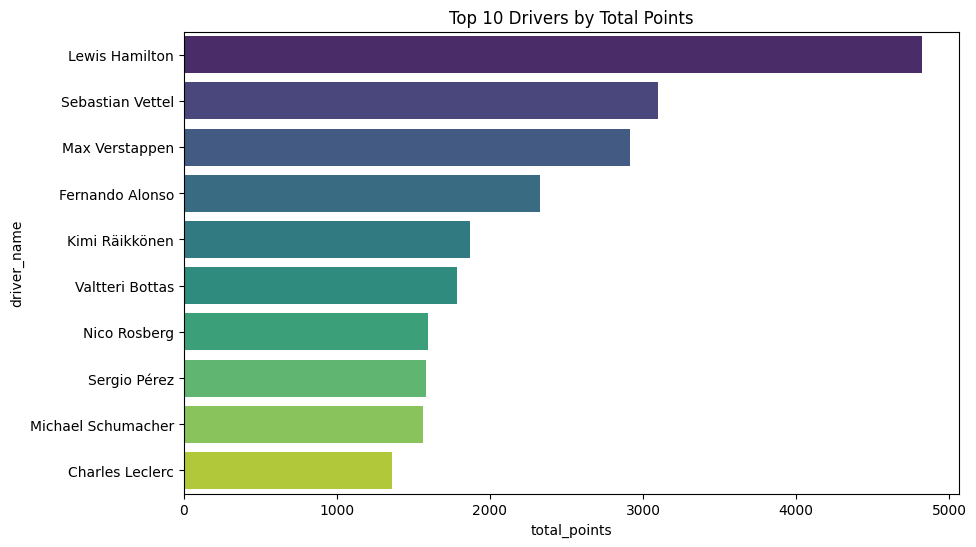

In [26]:
# Plot 1: Top 10 drivers by total points
import seaborn as sns
import matplotlib.pyplot as plt

top_drivers = df.withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
  .groupBy("driver_name") \
  .agg(_sum("points").alias("total_points")) \
  .orderBy(col("total_points").desc()) \
  .limit(10) \
  .toPandas()

plt.figure(figsize=(10,6))
sns.barplot(x="total_points", y="driver_name", data=top_drivers, palette="viridis")
plt.title("Top 10 Drivers by Total Points")
plt.show()


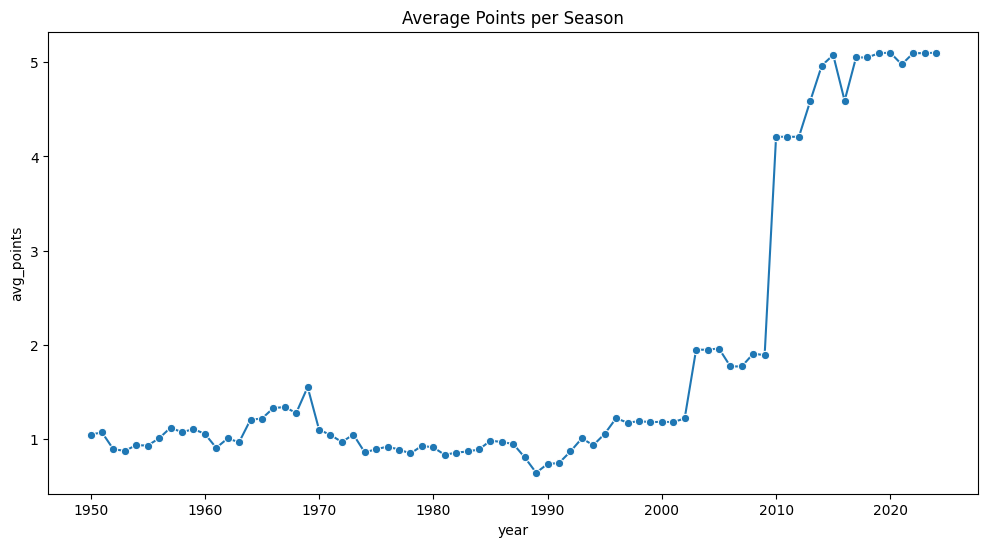

In [27]:
# Plot 2: Average points per season
avg_points_per_season = df.groupBy("year") \
    .agg(avg("points").alias("avg_points")) \
    .orderBy("year") \
    .toPandas()

plt.figure(figsize=(12,6))
sns.lineplot(x="year", y="avg_points", data=avg_points_per_season, marker="o")
plt.title("Average Points per Season")
plt.show()


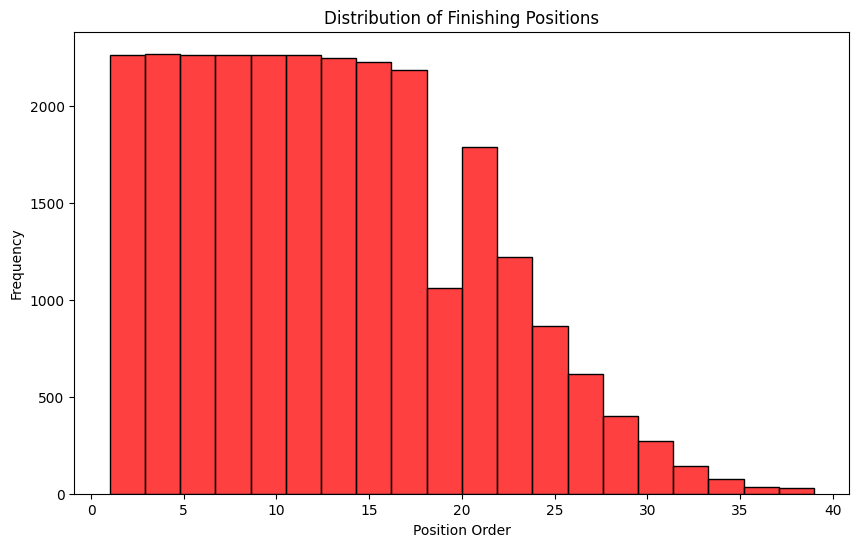

In [28]:
# Plot 3: Distribution of finishing positions
finish_positions = df.select("positionOrder").toPandas()

plt.figure(figsize=(10,6))
sns.histplot(finish_positions["positionOrder"], bins=20, kde=False, color="red")
plt.title("Distribution of Finishing Positions")
plt.xlabel("Position Order")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Team/Constructor Performance Analysis
print("\n" + "=" * 60)
print("TEAM/CONSTRUCTOR PERFORMANCE ANALYSIS")
print("=" * 60)

# Top teams by various metrics
team_performance = df.groupBy("constructorId") \
  .agg(
      _sum("points").alias("total_points"),
      count("raceId").alias("total_races"),
      _sum(when(col("positionOrder") == 1, 1).otherwise(0)).alias("wins"),
      _sum(when(col("positionOrder") <= 3, 1).otherwise(0)).alias("podiums"),
      avg("points").alias("avg_points_per_race"),
      countDistinct("driverId").alias("unique_drivers")
  ) \
  .withColumn("win_rate", (col("wins") / col("total_races") * 100).cast("decimal(5,2)")) \
  .withColumn("podium_rate", (col("podiums") / col("total_races") * 100).cast("decimal(5,2)")) \
  .orderBy(col("total_points").desc()) \
  .limit(15)

print("\nTop 15 Teams by Total Points:")
print("-" * 60)
team_performance.select("constructorId", "total_points", "total_races", "wins", "win_rate", "podiums", "podium_rate", "unique_drivers").show(15, truncate=False)


## 3. Statistical Insights and Correlations

### 3.1 Performance Correlations
Analyzing relationships between different performance metrics to identify key success factors.


In [ ]:
# Statistical Analysis and Correlations
print("\n" + "=" * 60)
print("STATISTICAL INSIGHTS AND CORRELATIONS")
print("=" * 60)

# Key correlations
print("\nKey Performance Correlations:")
print("-" * 40)
print(f"Points vs Grid Position: {df.stat.corr('points', 'grid'):.4f}")
print(f"Points vs Laps Completed: {df.stat.corr('points', 'laps'):.4f}")
print(f"Grid Position vs Finish Position: {df.stat.corr('grid', 'positionOrder'):.4f}")

# Performance by nationality
print("\n" + "=" * 60)
print("PERFORMANCE BY NATIONALITY")
print("=" * 60)

nationality_stats = df.groupBy("nationality") \
  .agg(
      countDistinct("driverId").alias("drivers"),
      _sum("points").alias("total_points"),
      _sum(when(col("positionOrder") == 1, 1).otherwise(0)).alias("wins"),
      avg("points").alias("avg_points_per_driver")
  ) \
  .orderBy(col("total_points").desc()) \
  .limit(10)

print("\nTop 10 Countries by Total Points:")
print("-" * 60)
nationality_stats.show(10, truncate=False)


## 4. Visualizations Summary

### 4.1 Key Performance Charts
The following visualizations provide graphical insights into F1 performance trends and distributions.


In [ ]:
# Enhanced Visualizations for Report
print("\n" + "=" * 60)
print("GENERATING ENHANCED VISUALIZATIONS")
print("=" * 60)

# Create a comprehensive visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('F1 Analytics Dashboard', fontsize=16, fontweight='bold')

# 1. Top 10 Drivers by Points (Enhanced)
top_drivers_viz = df.withColumn("driver_name", concat_ws(" ", col("forename"), col("surname"))) \
  .groupBy("driver_name") \
  .agg(_sum("points").alias("total_points")) \
  .orderBy(col("total_points").desc()) \
  .limit(10) \
  .toPandas()

axes[0,0].barh(range(len(top_drivers_viz)), top_drivers_viz['total_points'], color='skyblue')
axes[0,0].set_yticks(range(len(top_drivers_viz)))
axes[0,0].set_yticklabels(top_drivers_viz['driver_name'], fontsize=8)
axes[0,0].set_xlabel('Total Points')
axes[0,0].set_title('Top 10 Drivers by Total Points')

# 2. Win Distribution by Decade
decade_wins = df.withColumn("decade", (col("year") // 10) * 10) \
  .filter(col("positionOrder") == 1) \
  .groupBy("decade") \
  .count() \
  .orderBy("decade") \
  .toPandas()

axes[0,1].plot(decade_wins['decade'], decade_wins['count'], marker='o', linewidth=2, markersize=6)
axes[0,1].set_xlabel('Decade')
axes[0,1].set_ylabel('Number of Wins')
axes[0,1].set_title('Win Distribution by Decade')
axes[0,1].grid(True, alpha=0.3)

# 3. Circuit Distribution by Country
circuit_country = df.groupBy("country") \
  .count() \
  .orderBy(col("count").desc()) \
  .limit(8) \
  .toPandas()

axes[1,0].pie(circuit_country['count'], labels=circuit_country['country'], autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Race Distribution by Country (Top 8)')

# 4. Points vs Grid Position Scatter
sample_data = df.sample(0.1).select("grid", "points", "positionOrder").toPandas()
axes[1,1].scatter(sample_data['grid'], sample_data['points'], alpha=0.5, s=20)
axes[1,1].set_xlabel('Grid Position')
axes[1,1].set_ylabel('Points Earned')
axes[1,1].set_title('Points vs Grid Position (10% Sample)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization dashboard generated successfully!")
